In [ ]:
import numpy as np
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import qr
import scipy

# Localizable Multipartite Entanglement
##### in order to estimate L^tau, we must take the maximum of tau bar_beta over beta local... 

In [23]:
# standard n-tangle # <psi| sigma_y^{tensor n} |psi*>
def n_tangle(psi, N):
    # <psi| sigma_y^{tensor n} |psi*>
    # how many qubits: N
    assert 2**N == len(psi), "state vector length must be 2^n"
    # n tangle of odd qubits is 0
    if N % 2 == 1:
        return 0.0
    # single-qubit sigma_y
    sy = np.array([[0, -1j],[1j, 0]])
    # build sigma_y^{⊗N}
    Sy = sy
    for _ in range(N-1):
        Sy = np.kron(Sy, sy)
    # spin-flipped state
    psi_star = np.conjugate(psi)
    psi_tilde = Sy.dot(psi_star)
    z = np.dot(psi, psi_tilde)
    # The magnitude of z is exactly what you need, and it's a float.
    return np.abs(z)

# returns the Unitary matrix given phi, omega, and theta
def unitary(phi, omega, theta):
    a1 = np.exp(-1j*(phi + omega)/2)*np.cos(theta/2)
    a2 = -np.exp(1j*(phi - omega)/2) *np.sin(theta/2)
    a3 = np.exp(-1j*(phi - omega)/2) * np.sin(theta/2)
    a4 = np.exp(1j*(phi + omega)/2) * np.cos(theta/2)
    U = np.array([[a1, a2], [a3, a4]])
    return U

# returns the tensored unitary from a list of unitaries
def U_tensored(Us):
    U_p = Us[0]
    for i in range(1, len(Us)):
        U_p = np.kron(U_p, Us[i])
    return U_p

# input: an array of angle sets: [{theta_1, phi_1, omega_1}, {theta_2, phi_2, omega_2},...], state psi, and n_A, n_B
# returns the value of tau_bar for the angles, psi, n_A, and n_B
def tau_bar(angles, psi, n_A, n_B):
    d_B = 2**(n_B)
    Us = [] # store all unitaries that should be tensored
    if n_A == 1:
        U = unitary(angles[0], angles[1], angles[2])
    else:
        for i in range(0, len(angles), 3):
            theta = angles[i]
            phi = angles[i + 1]
            omega = angles[i + 2] 
            Us.append(unitary(theta, phi, omega))
        assert(len(Us) == n_A)
        U = U_tensored(Us) 
    
    # the two measurement outcomes:
    m0 = U[:,0]    
    m1 = U[:,1]    
    
    # build projectors ⟨m_i|⊗I
    I_B = np.eye(d_B)
    M0 = np.kron(m0.conj().T, I_B)   
    # print("Mo.shape", M0.shape)
    
    M1 = np.kron(m1.conj().T, I_B)
    # print("M1 shape", M1.shape)
    
    # apply and get probabilities + post‐states
    post0 = M0 @ psi
    post1 = M1 @ psi
    p0 = np.vdot(post0, post0).real
    p1 = np.vdot(post1, post1).real
    
    # if either branch is essentially zero, penalize heavily
    if p0 < 1e-12 or p1 < 1e-12:
        return 1e3 + (p0+p1)  # large positive
    
    psi0 = post0 / np.sqrt(p0)
    psi1 = post1 / np.sqrt(p1)
    
    # compute 2-tangles
    t0 = n_tangle(psi0, n_B)
    t1 = n_tangle(psi1, n_B)
    
    # weighted average, negated (since we minimize)
    return -(p0*t0 + p1*t1)

# use optimizer over L_tau, return max L_tau
def L_tau_opt(psi, n_A, n_B):
    # initial guess: random angles in [0,2π): scales with n_A
    x0 = np.random.rand(3*n_A) * 2*np.pi
    # constraints 0 ≤ x[i] ≤ 2π as inequality funcs for COBYLA: angle constraints (obvious)
    cons = []
    for i in range(3*n_A):
        cons.append({'type':'ineq', 'fun': lambda x, i=i: x[i]})
        cons.append({'type':'ineq', 'fun': lambda x, i=i: 2*np.pi - x[i]})
    res = minimize(
        tau_bar, x0,
        args=(psi, n_A, n_B),
        method='COBYLA',
        constraints=cons,
        options={'maxiter': 500, 'tol':1e-6, 'rhobeg':1.0}
    )
    # theta_opt, phi_opt, omega_opt = res.x
    max_Ltau = -res.fun
    # return max_Ltau, (theta_opt, phi_opt, omega_opt)
    return max_Ltau

# sample a vector of size N uniformly at random via haar measure (from pennylane)
def qr_haar(N):
    A, B = np.random.normal(size=(N, N)), np.random.normal(size=(N, N))
    Z = A + 1j * B

    Q, R = qr(Z)
    Lambda = np.diag([R[i, i] / np.abs(R[i, i]) for i in range(N)])

    U = np.dot(Q, Lambda)
    return U[:,0] 

# estimate L_tau by sampling N_samples Haar random states of size 2**(nA + nB) and averaging
def estimate_L_tau(nA, nB, N_samples=100):
    Ls = np.zeros(N_samples)
    for i in range(N_samples):
        psi = qr_haar(2**(nA + nB))  # Haar random state
        Li = L_tau_opt(psi, nA, nB)  # compute L_tau for this psi
        Ls[i] = Li
    return Ls.mean(), Ls.std()

# with one std
def L_vs_dB(nA, nB_values, N_samples=200):
    means, stds = [], []
    for nB in nB_values:
        mean, std = estimate_L_tau(nA, nB, N_samples)
        means.append(mean)
        stds.append(std)
    return np.array(means), np.array(stds)

# with one std
def L_vs_dA(nAs, nB, N_samples=200):
    means, stds = [], []
    for nA in nAs:
        mean, std = estimate_L_tau(nA, nB, N_samples)
        means.append(mean)
        stds.append(std)
    return np.array(means), np.array(stds)


## L vs nA with exponential fitting


In [ ]:
# Ltau vs nA with exponential fitting:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 16,
    "axes.titlesize": 18,
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

nA = 1
nA3 = 3
nA2 = 2



# 2) Choose a range of dB values that you can feasibly simulate.
#    (Remember: your state‐space dimension is 2**(dA+dB).)
nB_one = list(range(2, 9, 2))
nB_two = list(range(2, 9, 2))
nB_three = list(range(2, 9, 2)) 

# 3) Run the sweep
means = L_vs_dB(nA, nB_one)
means2 = L_vs_dB(nA2, nB_two)
means3=L_vs_dB(nA3, nB_three)

# # fit a curve
# deg = 2  # try 1 (linear), 2 (quadratic), … up to 4 for five pts
# coeffs = np.polyfit(nB_one, means, deg)
# poly = np.poly1d(coeffs)
# a, b, c = coeffs
# print(f"n_A=1: L = {a:.4f} n_B² + {b:.4f} n_B + {c:.4f}")

# x_fit = np.linspace(0, 8, 100)
# y_fit = poly(x_fit)  # or fitted(x_fit)

# plt.plot(x_fit, y_fit,  
#          color='C0',    
#          label='n_A = 1 fit')

# coeffs2 = np.polyfit(nB_two, means2, deg)
# poly2 = np.poly1d(coeffs2)
# a2, b2, c2 = coeffs2
# print(f"n_A=2: L = {a2:.4f} n_B² + {b2:.4f} n_B + {c2:.4f}")

# x_fit2 = np.linspace(0, 8, 100)
# y_fit2 = poly2(x_fit2)  # or fitted(x_fit)

# plt.plot(x_fit2, y_fit2, 
#          color='C1',     
#          label='n_A = 2 fit')

# coeffs3 = np.polyfit(nB_three, means3, deg)
# poly3 = np.poly1d(coeffs3)
# a3, b3, c3 = coeffs3
# print(f"n_A=3: L = {a3:.4f} n_B² + {b3:.4f} n_B + {c3:.4f}")

# x_fit3 = np.linspace(0, 8, 100)
# y_fit3 = poly3(x_fit3)  # or fitted(x_fit)

# plt.plot(x_fit3, y_fit3,  
#          color='C2',    
#          label='n_A = 3 fit')


plt.errorbar(nB_one, means, fmt='o', color='C0',label=r'$L^{\tau}$ for $n_A = 1$')
plt.errorbar(nB_two, means2, fmt='o', color='C1', label=r'$L^{\tau}$ for $n_A = 2$')
plt.errorbar(nB_three, means3, fmt='o', color='C2', label=r'$L^{\tau}$ for $n_A = 3$')
# Plot K(d_B) = sqrt(2/(d_B + 1)) points
for idx, nB in enumerate(nB_one):
    d_B = 2 ** nB
    K = np.sqrt(2 / (d_B + 1))
    plt.plot(nB, K, 'x', color='k', label='K($d_B$)' if idx == 0 else "")
plt.xlabel(r'$n_B$')
plt.ylabel(r'$L^{\tau}(|psi>)$')
plt.title(f'Est. $L$ vs $n_B$ for fixed $n_A$')
plt.legend()
plt.tight_layout()
plt.show()



# Work with Expectation Values

In [ ]:
# numerically show E_|psi> [|L^t(|psi>) - taubar_beta (|psi>)|]

# function to compute L^tau(psi) - _tau_beta (psi) for psi sampled uniformly at random and beta random basis.
def L_tau_bar_difference(psi, n_A, n_B):
    angles = np.random.rand(3*n_A) * 2*np.pi
    return np.abs(L_tau_opt(psi, n_A, n_B) - tau_bar(angles, psi, n_A, n_B))

def E_L_tau_bar_difference(n_A, n_B, num_samples=200):
    diffs = np.zeros(num_samples)
    for i in range(num_samples):
        psi = qr_haar(2**(n_A + n_B))
        diffs[i] = L_tau_bar_difference(psi, n_A, n_B)
    return diffs.mean()

#now, compute the Expectation value for various d_A, d_B values:

nA  = 1
nA2 = 2
nA3 = 3
nB_list  = list(range(2, 9, 2))   # [2, 4, 6]

N_samples = 200

# preallocate
diff_means = np.zeros(len(nB_list))
diff_stderr= np.zeros(len(nB_list))

diff_means2 = np.zeros(len(nB_list))
diff_stderr2= np.zeros(len(nB_list))

diff_means3 = np.zeros(len(nB_list))
diff_stderr3= np.zeros(len(nB_list))

# Monte Carlo sweep
for idx, nB in enumerate(nB_list):
    samples = np.zeros(N_samples)
    samples2 = np.zeros(N_samples)
    samples3 = np.zeros(N_samples)
    for i in range(N_samples):
        psi = qr_haar(2**(nA + nB))
        samples[i] = L_tau_bar_difference(psi, nA, nB)

        psi2 = qr_haar(2**(nA2 + nB))
        samples2[i] = L_tau_bar_difference(psi2, nA2, nB)

        psi3 = qr_haar(2**(nA3 + nB))
        samples3[i] = L_tau_bar_difference(psi3, nA3, nB)


    diff_means[idx]   = samples.mean()
    diff_stderr[idx]  = samples.std(ddof=1)/np.sqrt(N_samples)

    diff_means2[idx]   = samples2.mean()
    diff_stderr2[idx]  = samples2.std(ddof=1)/np.sqrt(N_samples)

    diff_means3[idx]   = samples3.mean()
    diff_stderr3[idx]  = samples3.std(ddof=1)/np.sqrt(N_samples)

# Plot
plt.errorbar(
    nB_list, diff_means,
    yerr=diff_stderr,
    fmt='o', color='C0',
    label=r'$n_A = 1$'
)

plt.errorbar(
    nB_list, diff_means2,
    yerr=diff_stderr2,
    fmt='o', color='C1',
    label=r'$n_A = 2$'
)

plt.errorbar(
    nB_list, diff_means3,
    yerr=diff_stderr3,
    fmt='o', color='C2',
    label=r'$n_A = 3$'
)
plt.xlabel(r'$n_B$')
plt.ylabel(r'$E[|L^{\tau}(|\psi \rangle)-\bar\tau(|\psi \rangle)|]$')
plt.title(f'Est. expectation vs $n_B$ for fixed $n_A$')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
def E_L_tau_bar(n_A, n_B, num_samples=50):
    diffs = np.zeros(num_samples)
    for i in range(num_samples):
        psi = qr_haar(2**(n_A + n_B))
        diffs[i] = L_tau_opt(psi, n_A, n_B)
    return diffs.mean()

#now, compute the Expectation value for various d_A, d_B values:
nA  = 1
nA2 = 2
nA3 = 3
nB_list  = list(range(2, 9, 2))   # [2, 4, 6]

N_samples = 200

# preallocate
diff_means = np.zeros(len(nB_list))
diff_stderr= np.zeros(len(nB_list))

diff_means2 = np.zeros(len(nB_list))
diff_stderr2= np.zeros(len(nB_list))

diff_means3 = np.zeros(len(nB_list))
diff_stderr3= np.zeros(len(nB_list))

# Monte Carlo sweep
for idx, nB in enumerate(nB_list):
    samples = np.zeros(N_samples)
    samples2 = np.zeros(N_samples)
    samples3 = np.zeros(N_samples)
    for i in range(N_samples):
        psi = qr_haar(2**(nA + nB))
        samples[i] = L_tau_opt(psi, nA, nB)

        psi2 = qr_haar(2**(nA2 + nB))
        samples2[i] = L_tau_opt(psi2, nA2, nB)

        psi3 = qr_haar(2**(nA3 + nB))
        samples3[i] = L_tau_opt(psi3, nA3, nB)


    diff_means[idx]   = samples.mean()
    diff_stderr[idx]  = samples.std(ddof=1)/np.sqrt(N_samples)

    diff_means2[idx]   = samples2.mean()
    diff_stderr2[idx]  = samples2.std(ddof=1)/np.sqrt(N_samples)

    diff_means3[idx]   = samples3.mean()
    diff_stderr3[idx]  = samples3.std(ddof=1)/np.sqrt(N_samples)

# Plot
plt.errorbar(
    nB_list, diff_means,
    yerr=diff_stderr,
    fmt='o', color='C0',
    label=r'$n_A = 1$'
)

plt.errorbar(
    nB_list, diff_means2,
    yerr=diff_stderr2,
    fmt='o', color='C1',
    label=r'$n_A = 2$'
)

plt.errorbar(
    nB_list, diff_means3,
    yerr=diff_stderr3,
    fmt='o', color='C2',
    label=r'$n_A = 3$'
)
plt.xlabel(r'$n_B$')
plt.ylabel(r'$E[L^{\tau}(|\psi \rangle)]$')
plt.title(r'$E[L^{\tau}_{local}(|\psi \rangle)]$ vs $E[L^{\tau}_{global}(|\psi \rangle)]')
plt.legend()
plt.tight_layout()
plt.show()



# Work for Corollary 17

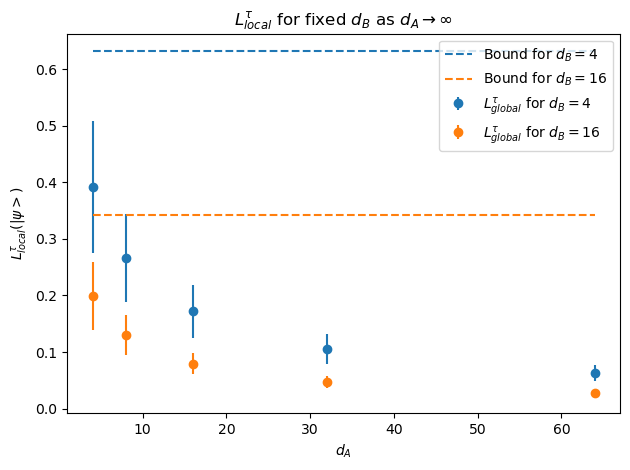

In [24]:
# l_tau for fixed dB, inc dA
nB = 2
nB2 = 4
def bound(dB):
    return np.sqrt(2/(dB + 1))
nA = list(range(2, 7))
dA = 2**np.array(nA)

means, stds = L_vs_dA(nA, nB, N_samples=1000)
means2, stds2 = L_vs_dA(nA, nB2, N_samples=1000)

plt.errorbar(dA, means, yerr=stds, fmt='o', color='C0',
             label=r'$L^{\tau}_{global}$ for $d_B = 4$')
plt.errorbar(dA, means2, yerr=stds2, fmt='o', color='C1',
             label=r'$L^{\tau}_{global}$ for $d_B = 16$')

plt.plot(dA, [bound(4)]*len(dA), 'C0--', label=r'Bound for $d_B=4$')
plt.plot(dA, [bound(16)]*len(dA), 'C1--', label=r'Bound for $d_B=16$')
plt.xlabel(r'$d_A$')
plt.ylabel(r'$L^{\tau}_{local}(|\psi>)$')
plt.title(r'$L^{\tau}_{local}$ for fixed $d_B$ as $d_A \rightarrow \infty$')
plt.legend()
plt.tight_layout()
plt.show()

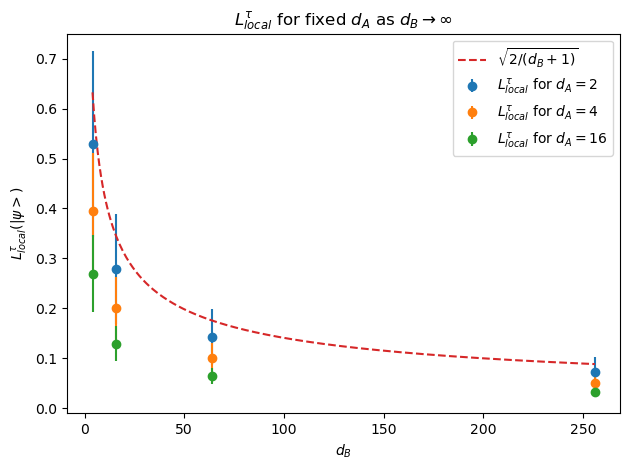

In [25]:
nA = 1
nA2 = 2
nA3 = 3


def bound(dB):
    return np.sqrt(2/(dB + 1))


nB = list(range(2, 9, 2))
dB = 2**np.array(nB)


dBmeans, dBstds = L_vs_dB(nA, nB, N_samples=1000)
dBmeans2, dBstds2 = L_vs_dB(nA2, nB, N_samples=1000)
dBmeans3, dBstds3 = L_vs_dB(nA3, nB, N_samples=1000)


plt.errorbar(dB, dBmeans, yerr = dBstds, fmt='o', color='C0',label=r'$L^{\tau}_{local}$ for $d_A = 2$')
plt.errorbar(dB, dBmeans2, yerr = dBstds2, fmt='o', color='C1',label=r'$L^{\tau}_{local}$ for $d_A = 4$')
plt.errorbar(dB, dBmeans3, yerr = dBstds3,fmt='o', color='C2',label=r'$L^{\tau}_{local}$ for $d_A = 16$')
dB_dense = np.linspace(dB.min(), dB.max(), 300)
plt.plot(dB_dense, bound(dB_dense), 'C3--', label=r'$\sqrt{2/(d_B + 1)}$')




plt.xlabel(r'$d_B$')
plt.ylabel(r'$L^{\tau}_{local}(|\psi>)$')
plt.title(r'$L^{\tau}_{local}$ for fixed $d_A$ as $d_B \rightarrow \infty$')
plt.legend()
plt.tight_layout()
plt.show()